# Credit Card Fraud Detection
## TU Delft CS 4035 & Adyen
### Bo Wang 4479599 Computer Science, track Data Science
### Jing Wang 4517938 Embedded System, track Software&Networking

### Library Dependency
+ python 2.7
+ pandas
+ numpy
+ sklearn
+ matplotlib
+ UnbalancedDataset (pip install git+https://github.com/fmfn/UnbalancedDataset)

### Table of Contents
1. #### Data Preprocessing
    - ##### 1.1 Missing Values
    - ##### 1.2 Numerical Features
    - ##### 1.3 Categorial Features (Dummy Variables)
    - ##### 1.4 First Classifier (Baseline)
2. #### Deal with Imbalanced Dataset
    - ##### 2.1 SMOTE and SMOTE Evaluation
    - ##### 2.2 SMOTE + TOMEK Link and Evalation
    - ##### 2.3 SMOTE + ENN and Evaluation
    - ##### 2.4 Best Ratio for Majority class vs Minority class
3. #### Feature Engineering & Data Aggregation
    - ##### 3.1 New Features
    - ##### 3.2 Data Aggregation
    - ##### 3.3 Dimensionality Reduction
    - ##### 3.4 Feature Scaling and Evaluation
4. #### Comparison between Different Classifiers
    - #### 4.1 LR, Logistic, SVM, KNN
    - #### 4.2 Boosting: Adaboost
    - #### 4.3 Bagging: RandomForest
    - #### 4.4 Conclusion
5. #### Parameter Turning
6. #### Future Exploration
7. #### Reference

## Data Proprocessing

In this section, I'm gonna start from data processing: deal with missing values, create numerical features, create categorical features, finished by the first simple & dirty classifier and evaluation reasult based on Confusion Matrix/Precison/Recall/F1 Score.

In [1]:
#import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
import sklearn
from unbalanced_dataset import SMOTE,SMOTETomek,SMOTEENN
pd.set_option('display.max_columns', 1000)#set disply column

In [2]:
df_credit = pd.read_csv("~/Documents/data_for_student_case.csv")#load data
df_credit.head()#first galance

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


### 1.1 Deal with Missing Values

Data is valuable, we don't want to waste each observation and need to make the most of our data. In this subsection, we're going to estimate the relationship between different variables and try to impute missing variables. First check how many features contains NAN:

In [3]:
df_credit.isnull().sum()#count nan from our dataset

txid                                0
bookingdate                         0
issuercountrycode                 493
txvariantcode                       0
bin                               140
amount                              0
currencycode                        0
shoppercountrycode                482
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    14717
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64

Missing values exists in four features, include *issuercountrycode*, *bin*, *shoppercountrycode* and *cardverificationcodesupplied*. 

Start to look at *issuercountrycode*. According to data description, this feature represents for country where the card was issued, make an assumption that there exist a strong relationship between *issuercountrycode* and *currencycode*. Validate the hypothesis:

In [4]:
def validate_relationship_col3_col7():
    """Validate whether there is a strong relationsip between issuercountrycode and currencycode
    Returns:
        percentage(float): percentage of observation where issuercountrycode = first two letters of currency code
    """
    count = 0#count of rows has a relationship
    total = len(df_credit.index)
    for index, row in df_credit.iterrows():
        if row['issuercountrycode'] == row['currencycode'][0:2]:
            count += 1
        else:
            pass
    percentage = count/total
    return percentage

print(validate_relationship_col3_col7())

0.9593363224993284


Result: 95.93%. 

We believe that in most cases, missing value of column *issuercountrycode* can be impute by first two letter of *currencycode*.

In [5]:
def impute_issuercountrycode(df):
    """Impute missing value of feature issuercountrycode by first two letters of currencycode
    Args:
        df(pandas.dataframe): dataframe contains missing value of feature issuercountrycode
    Returns:
        df(pandas.dataframe): dataframe that missing value of issuercountrycode has been imputed
    """
    for index, row in df.iterrows():
        if pd.isnull(row['issuercountrycode']) == True:
            df.set_value(index, 'issuercountrycode', row['currencycode'][0:2])
    return df

df_credit_impute = impute_issuercountrycode(df_credit)
df_credit_impute.isnull().sum()

txid                                0
bookingdate                         0
issuercountrycode                   0
txvariantcode                       0
bin                               140
amount                              0
currencycode                        0
shoppercountrycode                482
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    14717
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64

Feature *shoppercountrycode* may also has a strong relationship with *currencycode*, since most people use credit card in their hometown. Validate the hypothesis:

In [6]:
def validate_relationship_col8_col7():
    """Validate whether there is a strong relationsip between shoppercountrycode and currencycode
    Returns:
        percentage(float): percentage of observation where issuercountrycode = first two letters of currency code
    """
    count = 0#count of rows has a relationship
    total = len(df_credit.index)
    for index, row in df_credit.iterrows():
        if row['shoppercountrycode'] == row['currencycode'][0:2]:
            count += 1
        else:
            pass
    percentage = count/total
    return percentage

print(validate_relationship_col8_col7())

0.9634033789973208


Result: 96.34%.

we believe in most cases, missing value of column shoppercountrycode can be impute by first two letter of currencycode.

In [7]:
def impute_shoppercountrycode(df):
    """Impute missing value of shoppercountrycode by first two letters of currencycode
    Args:
        df(pandas.dataframe): dataframe contains missing value of feature shoppercountrycode
    Returns:
        df(pandas.dataframe): dataframe that missing value of shoppercountrycode has been imputed
    """
    for index, row in df.iterrows():
        if pd.isnull(row['shoppercountrycode']) == True:
            df.set_value(index, 'shoppercountrycode', row['currencycode'][0:2])
    return df

df_credit_impute = impute_shoppercountrycode(df_credit_impute)
df_credit_impute.isnull().sum()

txid                                0
bookingdate                         0
issuercountrycode                   0
txvariantcode                       0
bin                               140
amount                              0
currencycode                        0
shoppercountrycode                  0
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    14717
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64

Start to work on missing values of *cardverificationcodesupplied*. Over 14000 Nans in this feature.

Description: did the shopper provide his 3 digit CVC/CVV2 code?

I want to look through the data: which group of feature most likely has a nan value of CVV/CVV2?

In [8]:
#filter data did not provide CVV/CVV2, and group by currency code
df_not_provide_CVV = df_credit_impute[df_credit_impute['cardverificationcodesupplied'].isnull()]
df_not_provide_CVV.groupby(['currencycode']).agg(['count'])

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count
currencycode,,,,,,,,,,,,,,,,
AUD,99,99,99,99,99,99,99,99,99,0,99,99,99,99,99,99
GBP,14523,14523,14523,14523,14523,14523,14523,14523,14523,0,14523,14523,14523,14523,14523,14523
NZD,27,27,27,27,27,27,27,27,27,0,27,27,27,27,27,27
SEK,68,68,68,68,68,68,68,68,68,0,68,68,68,68,68,68


In most cases, user holds GBP as their currency didn't provide their CVV2 number. 

Then what's the percentage of user use GBP that provided a CVV/CVV2 number?

In [9]:
def cvv_percentage():
    """Check the percentage of user use GBP that provided a CVV/CVV2 number
    """
    df_credit_gbp = df_credit_impute[df_credit_impute.currencycode == "GBP"]
    true_count = 0
    false_count = 0
    nan_count = 0
    total_count = len(df_credit_gbp.index)
    for index, row in df_credit_gbp.iterrows():
        if row['cardverificationcodesupplied'] == True:
            true_count +=1
        elif row['cardverificationcodesupplied'] == False:
            false_count +=1
        else:
            nan_count += 1
    print("Percentage People use GBP provided CVV/CVV2:" + str(true_count/total_count))
    print("Percentage People use GBP did not provide CVV/CVV2:" + str(false_count/total_count))
    print("Percentage People use GBP found nan CVV/CVV2:" + str(nan_count/total_count))

cvv_percentage() 

Percentage People use GBP provided CVV/CVV2:0.895083721849643
Percentage People use GBP did not provide CVV/CVV2:0.03489655903921162
Percentage People use GBP found nan CVV/CVV2:0.07001971911114539


89% percentage of user that use GBP provided a CVV/CVV2 number, only 3% user did not provide the CVV number (7% missing values). 

Hence we proved that in most cases, users will provide a CVV/CVV2 number. For this reason, I imputed the missing value of cardverificationcodesupplied with True.

In [10]:
def impute_cardverificationcodesupplied(df):
    """Impute missing value of cardverificationcodesupplied with True
    Args:
        df(pandas.dataframe): dataframe contains missing value of feature cardverificationcodesupplied
    Returns:
        df(pandas.dataframe): dataframe that missing value of cardverificationcodesupplied has been imputed
    """
    for index, row in df.iterrows():
        if pd.isnull(row['cardverificationcodesupplied']) == True:
            df.set_value(index, 'cardverificationcodesupplied', True)
    return df

df_credit_impute = impute_cardverificationcodesupplied(df_credit_impute)
df_credit_impute.isnull().sum()

txid                              0
bookingdate                       0
issuercountrycode                 0
txvariantcode                     0
bin                             140
amount                            0
currencycode                      0
shoppercountrycode                0
shopperinteraction                0
simple_journal                    0
cardverificationcodesupplied      0
cvcresponsecode                   0
creationdate                      0
accountcode                       0
mail_id                           0
ip_id                             0
card_id                           0
dtype: int64

For *bin* feature, there exist 140 missing values. 

Descroption of *bin*: card issuer identifier.

According to the description, maybe it's hard to estimate using other features. Validate:

In [11]:
print(df_credit_impute.bin.unique())#check unique card issue identifier, is a long list
print(len(df_credit_impute.bin.unique()))#include 4117 unique identifiers, seems unable to estimate

[ 530056.  547046.  528843. ...,  557385.  546898.  485807.]
4117


In [12]:
140/len(df_credit_impute.index)#calculate proportion of nan in bin

0.00048212354760281286

Can be seen that nan only account for 0.048% in total, so here I removed this part of missing values.

In [13]:
df_credit_impute = df_credit_impute.dropna()#drop na values
df_credit_impute.isnull().sum()#no missing values left

txid                            0
bookingdate                     0
issuercountrycode               0
txvariantcode                   0
bin                             0
amount                          0
currencycode                    0
shoppercountrycode              0
shopperinteraction              0
simple_journal                  0
cardverificationcodesupplied    0
cvcresponsecode                 0
creationdate                    0
accountcode                     0
mail_id                         0
ip_id                           0
card_id                         0
dtype: int64

In [14]:
df_credit_impute.head()#finish missing value handling

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


### 1.2 Numerical Features

The values of a numerical variable are numbers. Try to find numerical varlables in our feature space.

In [15]:
df_credit_copy = df_credit_impute.copy()# make a copy of original dataset
numeric_variables = list(df_credit_copy.dtypes[df_credit_copy.dtypes != "object"].index)
df_credit_copy[numeric_variables].head()

,txid,bin,amount,cvcresponsecode
0,1,530056.0,64800.0,0
1,2,547046.0,44900.0,0
2,3,528843.0,149900.0,0
3,4,547146.0,109900.0,0
4,5,477291.0,89900.0,0


Column *txid* seems to have no use for our classifier since it's just the sequence of observations, so delete this column.

Feature *bin* stands for *card issuer identifier*, currently we do not whether this feature is useful or not, or whether do feature normalization will help, leave it to section **Feature Engineering and Data Aggregation**.

For feature *amount*, we keep the same as *bin*, maybe needs normalization, discuss in next section.

Feature *cvcresponsecode*, description: Validation result of the CVC/CVV2 code: 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked. Basically 3-6 stands for the same situation, so we set 4,5,6 to 3:

In [16]:
def modify_cvcresponsecode(df):
    """Modify cvcresponsecode, change value 4,5,6 to 3 as they as the same meaning.
    Args:
        df(pandas.dataframe): dataframe where feature cvcresponsecode contains 4,5,6
    Returns:
        df(pandas.dataframe): dataframe where feature cvcresponsecode 4,5,6 was replaced by 3
    """
    for index, row in df.iterrows():
        if row['cvcresponsecode'] == 4:
            df.set_value(index, 'cvcresponsecode', 3)
        elif row['cvcresponsecode'] == 5:
            df.set_value(index, 'cvcresponsecode', 3)
        elif row['cvcresponsecode']==6:
            df.set_value(index, 'cvcresponsecode', 3)
    return df

modify_cvcresponsecode(df_credit_copy)
df_credit_copy.cvcresponsecode.unique()

array([0, 1, 3, 2])

In [17]:
df_credit_copy.drop(['txid'], axis=1, inplace=True) #txid is an index column that useless, remove the column

Now we've finished handle numerical features, start to work on categorical features.

### 1.3 Categorical Features

In [18]:
def describe_categorical(df):
    """Describe categorical variables
    Args:
        df(pandas.dataframe): dataframe to extract categorical variables
    """
    from IPython.display import display, HTML
    display(HTML(df[df.columns[df.dtypes=='object']].describe().to_html()))
describe_categorical(df_credit_copy)

,bookingdate,issuercountrycode,txvariantcode,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,creationdate,accountcode,mail_id,ip_id,card_id
count,290242,290242,290242,290242,290242,290242,290242,290242,290242,290242,290242,290242,290242
unique,92814,136,15,5,153,3,3,2,283890,4,220930,220418,234690
top,2015-10-06 22:24:34,GB,visadebit,GBP,GB,Ecommerce,Settled,True,2015-08-22 10:12:01,UKAccount,email170659,ip17828,card210128
freq,59,200600,172513,207331,199711,282015,236691,282005,7,207331,436,505,443


13 categorical features can be found in data. 

First look at feature *mail_id*, *ip_id* and *card_id*, have 290242 values in total, and have over 220000 unique valuels. It is not likely to be a good measurement for fraud detection, so remove this three columns first.

In [19]:
#remove mail_id, ip_id, card_id
df_credit_copy.drop(['mail_id'], axis=1, inplace=True)
df_credit_copy.drop(['ip_id'], axis=1, inplace=True)
df_credit_copy.drop(['card_id'], axis=1, inplace=True)

Look at two time features:

**bookingdate**, only relevant for Chargebacks. Time stamp when the chargeback was reported. During simulation you may only use this knowledge after this date. So for example if on an email address a transaction ended in a chargeback, you can only block that email address after the booking date of the chargeback.

**creationdate**, Date of transaction.

In this section, we first ignore these two features, and try to do aggregating in part 3.

In [20]:
df_credit_fe = df_credit_copy#restore data, this will be used in section 3, feature engineering
df_credit_copy.drop(['bookingdate'], axis=1, inplace=True)
df_credit_copy.drop(['creationdate'], axis=1, inplace=True)
df_credit_copy.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,accountcode
0,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,MexicoAccount
1,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,MexicoAccount
2,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,MexicoAccount
3,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,MexicoAccount
4,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,MexicoAccount


Use these features to create **dummy variables**(except label column simple_journal):

In [21]:
categorical_variables = ['issuercountrycode','txvariantcode','currencycode','shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied','cvcresponsecode', 'accountcode',]
for variable in categorical_variables:
    dummies = pd.get_dummies(df_credit_copy[variable], prefix=variable)
    df_credit_copy=pd.concat([df_credit_copy, dummies], axis=1)
    df_credit_copy.drop([variable], axis=1, inplace=True)
df_credit_copy.head()#view x with dummy variables

,bin,amount,simple_journal,issuercountrycode_AD,issuercountrycode_AE,issuercountrycode_AI,issuercountrycode_AL,issuercountrycode_AM,issuercountrycode_AO,issuercountrycode_AR,issuercountrycode_AT,issuercountrycode_AU,issuercountrycode_AZ,issuercountrycode_BA,issuercountrycode_BB,issuercountrycode_BD,issuercountrycode_BE,issuercountrycode_BF,issuercountrycode_BG,issuercountrycode_BH,issuercountrycode_BJ,issuercountrycode_BM,issuercountrycode_BN,issuercountrycode_BO,issuercountrycode_BR,issuercountrycode_BS,issuercountrycode_BW,issuercountrycode_BY,issuercountrycode_BZ,issuercountrycode_CA,issuercountrycode_CD,issuercountrycode_CG,issuercountrycode_CH,issuercountrycode_CK,issuercountrycode_CL,issuercountrycode_CM,issuercountrycode_CN,issuercountrycode_CO,issuercountrycode_CR,issuercountrycode_CV,issuercountrycode_CW,issuercountrycode_CY,issuercountrycode_CZ,issuercountrycode_DE,issuercountrycode_DK,issuercountrycode_DO,issuercountrycode_DZ,issuercountrycode_EC,issuercountrycode_EE,issuercountrycode_EG,issuercountrycode_ES,issuercountrycode_FI,issuercountrycode_FJ,issuercountrycode_FR,issuercountrycode_GB,issuercountrycode_GE,issuercountrycode_GH,issuercountrycode_GI,issuercountrycode_GR,issuercountrycode_GT,issuercountrycode_HK,issuercountrycode_HN,issuercountrycode_HR,issuercountrycode_HU,issuercountrycode_ID,issuercountrycode_IE,issuercountrycode_IL,issuercountrycode_IN,issuercountrycode_IQ,issuercountrycode_IS,issuercountrycode_IT,issuercountrycode_JM,issuercountrycode_JO,issuercountrycode_JP,issuercountrycode_KE,issuercountrycode_KH,issuercountrycode_KR,issuercountrycode_KW,issuercountrycode_KY,issuercountrycode_KZ,issuercountrycode_LA,issuercountrycode_LB,issuercountrycode_LK,issuercountrycode_LT,issuercountrycode_LU,issuercountrycode_LV,issuercountrycode_LY,issuercountrycode_MD,issuercountrycode_ME,issuercountrycode_MK,issuercountrycode_MN,issuercountrycode_MO,issuercountrycode_MT,issuercountrycode_MU,issuercountrycode_MV,issuercountrycode_MX,issuercountrycode_MY,issuercountrycode_NG,issuercountrycode_NL,issuercountrycode_NO,issuercountrycode_NZ,issuercountrycode_OM,issuercountrycode_PA,issuercountrycode_PE,issuercountrycode_PH,issuercountrycode_PK,issuercountrycode_PL,issuercountrycode_PR,issuercountrycode_PT,issuercountrycode_PY,issuercountrycode_QA,issuercountrycode_RO,issuercountrycode_RS,issuercountrycode_RU,issuercountrycode_SA,issuercountrycode_SB,issuercountrycode_SE,issuercountrycode_SG,issuercountrycode_SI,issuercountrycode_SK,issuercountrycode_SL,issuercountrycode_SV,issuercountrycode_TH,issuercountrycode_TJ,issuercountrycode_TM,issuercountrycode_TR,issuercountrycode_TT,issuercountrycode_TW,issuercountrycode_TZ,issuercountrycode_UA,issuercountrycode_US,issuercountrycode_UY,issuercountrycode_VE,issuercountrycode_VG,issuercountrycode_VN,issuercountrycode_ZA,issuercountrycode_ZM,issuercountrycode_ZW,issuercountrycode_ZZ,txvariantcode_cirrus,txvariantcode_electron,txvariantcode_mc,txvariantcode_mccredit,txvariantcode_mcdebit,txvariantcode_visa,txvariantcode_visabusiness,txvariantcode_visaclassic,txvariantcode_visacorporate,txvariantcode_visadebit,txvariantcode_visagold,txvariantcode_visaplatinum,txvariantcode_visapurchasing,txvariantcode_visasignature,txvariantcode_vpay,currencycode_AUD,currencycode_GBP,currencycode_MXN,currencycode_NZD,currencycode_SEK,shoppercountrycode_AE,shoppercountrycode_AF,shoppercountrycode_AG,shoppercountrycode_AL,shoppercountrycode_AM,shoppercountrycode_AO,shoppercountrycode_AR,shoppercountrycode_AT,shoppercountrycode_AU,shoppercountrycode_AX,shoppercountrycode_AZ,shoppercountrycode_BA,shoppercountrycode_BB,shoppercountrycode_BD,shoppercountrycode_BE,shoppercountrycode_BG,shoppercountrycode_BH,shoppercountrycode_BJ,shoppercountrycode_BM,shoppercountrycode_BN,shoppercountrycode_BO,shoppercountrycode_BR,shoppercountrycode_BS,shoppercountrycode_BW,shoppercountrycode_BY,shoppercountrycode_CA,shoppercountrycode_CD,shoppercountrycode_CH,shoppercountrycode_CI,shoppercountrycode_CK,shoppercountryco

### 1.4 First Model

In this subsection, I used the previous numerical vairbales and categorical variables to create my first model. We employed three classifiers, including knn, logistic and RandomForest, test with ConfusionMatrix, Precision/Recall, F1 Score.

At the moment, there exists three labels. According to description: Payment status. Authorised = “transaction approved and no fraud reported”, Refused = “transaction was declined, can be fraud, but can also be insufficient funds, etc”, Chargeback = “transaction was approved, but turned out to be fraud”. At present, I'll not use the data labeled with *Refused*, later on in section *Future Exploration*, I'll try to dive into this part of data.

In [22]:
df_credit_copy = df_credit_copy[df_credit_copy.simple_journal != "Refused"]#filter label with Refused
X = df_credit_copy#create a copy of dataset
X = X.reindex(np.random.permutation(X.index))#shuffle original dataframe

In [23]:
def replace_label(label):
    """Replace label from str to 0 and 1
    Args:
        label(pandas.series): series of label
    """
    if label =="Settled":
        return 0
    elif label =="Chargeback":
        return 1
    else:
        raise ValueError("unrecognized label type")

X['simple_journal'] = X.simple_journal.apply(replace_label)
y = X.pop('simple_journal')#assign  label to y
y.unique()

array([0, 1])

In [24]:
def evaluate_feature(X_train, X_test, y_train, y_test):
    """Use varies classifiers to evaluate based on confusion matrix, recall, precision, f1, using hold out crossvalidation
    Args:
        X_train(pandas.dataframe): training data
        X_test(pandas.dataframe): testing data
        y_train(pandas.series): training label
        y_test(pandas.series): testing label
    """
    #train classifier
    knn = neighbors.classification.KNeighborsClassifier()
    logistic = linear_model.LogisticRegression()
#     svc = svm.SVC(kernel="rbf")
    forest = ensemble.RandomForestClassifier()
    #fit data
    knn.fit(X_train, y_train)
    logistic.fit(X_train, y_train)
#     svc.fit(X_train, y_train)
    forest.fit(X_train, y_train)
    #make prediction
    y_pred_knn = knn.predict(X_test)
    y_pred_log = logistic.predict(X_test)
#     y_pred_svm = svc.predict(X_test)
    y_pred_forest = forest.predict(X_test)
    print(metrics.confusion_matrix(y_test,y_pred_knn))
    print("KNN Recall: " + str(metrics.recall_score(y_test,y_pred_knn)))
    print("KNN Precision: " + str(metrics.precision_score(y_test, y_pred_knn)))
    print("KNN F1: " + str(metrics.f1_score(y_test, y_pred_knn)))
    
    print(metrics.confusion_matrix(y_test,y_pred_log))
    print("Logistic Recall: " + str(metrics.recall_score(y_test,y_pred_log)))
    print("Logistic Precision: " + str(metrics.precision_score(y_test, y_pred_log)))
    print("Logistic F1: " + str(metrics.f1_score(y_test, y_pred_log)))
    print(metrics.confusion_matrix(y_test, y_pred_forest))
    print("RF Recall: " + str(metrics.recall_score(y_test,y_pred_forest)))
    print("RF Precision: " + str(metrics.precision_score(y_test, y_pred_forest)))
    print("RF F1: " + str(metrics.f1_score(y_test, y_pred_forest)))

In [25]:
from sklearn import cross_validation
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, random_state =0)#train test split
evaluate_feature(X_train, X_test, y_train, y_test)

[[59175     1]
 [   81     2]]
KNN Recall: 0.0240963855422
KNN Precision: 0.666666666667
KNN F1: 0.046511627907
[[59173     3]
 [   83     0]]
Logistic Recall: 0.0
Logistic Precision: 0.0
Logistic F1: 0.0
[[59148    28]
 [   79     4]]
RF Recall: 0.0481927710843
RF Precision: 0.125
RF F1: 0.0695652173913


Can be found that the performance is really bad, only 1-3 TN can be found with these pre-defined model. In next section, we'll start to deal with the imbalanced dataset.

## 2. Deal with Imbalanced Dataset

Inspired by papaer [1][2][3], three kinds of imbalanced-learning technique will by tested, including:

1. SMOTE
2. SMOTE + TOMEKLINK
3. SMOTE + ENN

We first try to re-balance the dataset into 50-50 proption, and compare with approach lead to a better performance. Then try to evaluate result based on different ratio between majority class and minority class.

### 2.1 SMOTE

SMOTE, Synthetic Minority Oversampling Technique. Basically, SMOTE try to compute eculidean distance between each instance of minority class and get it's k nearest neighbour (most cases k = 6), according to pre-defiend ratio, add new minority points to minority class.

In [26]:
verbose = False
ratio = float(np.count_nonzero(y==0)) / float(np.count_nonzero(y==1))
ratio#majority class is 686 times larger than minority class

686.0608695652174

In [27]:
X_matrix = X.as_matrix()
y_matrix = y.as_matrix()

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_matrix, y_matrix, random_state =1)#train test split

In [28]:
#resampling using smote
smote = SMOTE(ratio=ratio, verbose=verbose, kind='regular')
X_smote, y_smote = smote.fit_transform(X_train, y_train)

In [29]:
evaluate_feature(X_smote, X_test, y_smote, y_test)

[[57145  2032]
 [   64    18]]
KNN Recall: 0.219512195122
KNN Precision: 0.00878048780488
KNN F1: 0.0168855534709
[[52902  6275]
 [   31    51]]
Logistic Recall: 0.621951219512
Logistic Precision: 0.00806196648751
Logistic F1: 0.0159176029963
[[58934   243]
 [   68    14]]
RF Recall: 0.170731707317
RF Precision: 0.0544747081712
RF F1: 0.0825958702065


As we can seen from smote result, we improved TN from 1-3 to 12-49, also paid a price on FN.

### 2.2 SMOTE + TOMEK LINKs

Tomek Links is kind of undersampling technique, this function try to remove *tomek link* between different class of data sets in order to re-balance data. Combine SMOTE and Tomek lins is able to bring better sampling result[2].

In [30]:
stk = SMOTETomek(ratio=ratio, verbose=verbose)
X_stk, y_stk = stk.fit_transform(X_train, y_train)
evaluate_feature(X_stk, X_test, y_stk, y_test)

[[57128  2049]
 [   64    18]]
KNN Recall: 0.219512195122
KNN Precision: 0.00870827285922
KNN F1: 0.016751977664
[[52870  6307]
 [   30    52]]
Logistic Recall: 0.634146341463
Logistic Precision: 0.00817738638151
Logistic F1: 0.016146561093
[[58896   281]
 [   68    14]]
RF Recall: 0.170731707317
RF Precision: 0.0474576271186
RF F1: 0.0742705570292


### 2.3 SMOTE + EEN

In [31]:
seen = SMOTEENN(ratio=ratio, verbose=verbose)
X_een, y_een = seen.fit_transform(X_train, y_train)
evaluate_feature(X_een, X_test, y_een, y_test)

[[56983  2194]
 [   64    18]]
KNN Recall: 0.219512195122
KNN Precision: 0.00813743218807
KNN F1: 0.0156931124673
[[52782  6395]
 [   28    54]]
Logistic Recall: 0.658536585366
Logistic Precision: 0.00837339122345
Logistic F1: 0.0165365181442
[[58793   384]
 [   64    18]]
RF Recall: 0.219512195122
RF Precision: 0.044776119403
RF F1: 0.0743801652893


### Best Ratio

After applying varies resampling techniques, we found that SMOTE + Tmoek Links ourperform than SMOTE and SMOTE EEN, we decided to apply this technique to re-balance the dataset. But there is still one thing need to be take into consideration: what is the best ratio for majority and minority class? Evaluate in this section:

In [32]:
# for r in [10,50,100,200,300,400,500,600,680,800,900]:
#     print "Current Ratio is " + str(r) + ": "
#     seen = SMOTEENN(ratio=ratio, verbose=verbose)
#     X_een, y_een = seen.fit_transform(X_train, y_train)
#     evaluate_feature(X_een, X_test, y_een, y_test)
# print "Finished"

In this section, we found SMOTE + EEN is able to provide better sampling result. Meanwhile, try to use ratio = 800 is likely to be the best choice.

## 3. Feature Engineering and Data Aggregation

Feature engineering is so important to how your model performs, that even a simple model with great features can outperform a complicated algorithm with poor ones. How much one understand the data, with your human intuition and creativity, can make the difference. Basically, it's need domain knowledge. In this section, I'll try to create some features, evaluate feature importance and select most important features.

### 3.1 New Features and Data Aggregation

In [33]:
#use prepared dataframe for feature engineering
df_credit_fe = df_credit_impute
df_credit_fe = df_credit_fe[df_credit_fe.simple_journal != "Refused"]#filter label with Refused
df_credit_fe['simple_journal'] = df_credit_fe.simple_journal.apply(replace_label)#replace label to 0 and 1
df_credit_fe.drop(['txid'], axis=1, inplace=True) #txid is an index column that useless, remove the column
df_credit_fe.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,1,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,1,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,1,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [34]:
df_credit_fe.txvariantcode.unique()#take a look at visa type

array(['mccredit', 'visaclassic', 'mcdebit', 'visagold', 'visaplatinum',
       'visadebit', 'visabusiness', 'visa', 'mc', 'visacorporate',
       'electron', 'visasignature', 'visapurchasing'], dtype=object)

Cards can be seperated into 2 categories: master card and visa:

In [35]:
def construct_card_type(df):
    """Construct feature named card type indicates whether it's a visa or master card
    Args:
        df(pandas.dataframe): dataframe of user input
    Returns:
        dataframe(pandas.dataframe): dataframe with new feature
    """
    visa_cards = ['visadebit','visagold','visaclassic','visaplatinum','visabusiness','visa','visasignature','visacorporate','visapurchasing','electron']
    master_cards = ['mccredit','mcdebit','mc']
    type_list = []
    for index, row in df.iterrows():
        if row['txvariantcode'] in visa_cards:
            type_list.append("v")
        elif row['txvariantcode'] in master_cards:
            type_list.append("m")
    df['card_type'] = pd.Series(type_list, index=df.index)
    return df

df_credit_fe = construct_card_type(df_credit_fe)#create a feature indicate it's a master card or visa card
df_credit_fe.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,card_type
0,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,1,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,m
1,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,m
2,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,m
3,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,1,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,m
4,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,1,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,v


Check whether different type of card may have different level of dangerous. For example, we make a hppothesis that goldn card is more prond to be the target of fraud: validate the hypothesis:

In [36]:
#visualize which type of card is more dangerous, we only care Chargeback level at the moment
danger_level = pd.crosstab(df_credit_fe.txvariantcode, df_credit_fe.simple_journal).apply(lambda r: r/r.sum(), axis=1)
danger_level.sort([1], ascending=[False])#sort by dangerous level, 1 indicates chargeback

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


simple_journal,0,1
txvariantcode,,
visapurchasing,0.950000,0.050000
visasignature,0.983278,0.016722
visabusiness,0.983333,0.016667
visaclassic,0.994048,0.005952
visagold,0.995797,0.004203
visaplatinum,0.996324,0.003676
mccredit,0.996994,0.003006
visa,0.997118,0.002882
mcdebit,0.998988,0.001012


We're able to find that visapurchasing is very dangerous since 5 over 100 user may suffer from fraud. Based on the different level, create a feature:

In [37]:
def construct_dangeous_card(df):
    """Construct feature named danger_level indicates which card is more liley to be hacked
    Args:
        df(pandas.dataframe): dataframe of user input
    Returns:
        dataframe(pandas.dataframe): dataframe with new feature
    """
    dangerous = ['visapurchasing','visasignature']
    median = ['visabusiness','visaclassic','visaplatinum','visagold','mccredit','visa']
    secure = ['mcdebit','visadebit','cirrus','electron','mc','visacorporate','vpay']
    danger_level = []
    for index, row in df.iterrows():
        if row['txvariantcode'] in dangerous:
            danger_level.append("dangerous")
        elif row['txvariantcode'] in median:
            danger_level.append("median")
        elif row['txvariantcode'] in secure:
            danger_level.append("secure")
    df['danger_level'] = pd.Series(danger_level, index=df.index)
    return df
df_credit_fe = construct_dangeous_card(df_credit_fe)
df_credit_fe.head() 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,card_type,danger_level
0,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,1,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,m,median
1,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,m,median
2,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,m,median
3,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,1,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,m,median
4,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,1,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,v,median


Also want to know how issue place can post an impact on simple_journal, is there any region natually lack of strict law that result in high level of creadit card fraud rate?

In [38]:
danger_region = pd.crosstab(df_credit_fe.issuercountrycode, df_credit_fe.simple_journal).apply(lambda r: r/r.sum(), axis=1)
danger_region.sort([1], ascending=[False])#sort by dangerous level

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


simple_journal,0,1
issuercountrycode,,
BR,0.823529,0.176471
FI,0.846154,0.153846
JO,0.928571,0.071429
ID,0.933333,0.066667
NL,0.937500,0.062500
MY,0.968750,0.031250
DE,0.981481,0.018519
MX,0.984608,0.015392
NO,0.991228,0.008772


In [39]:
def construct_dangeous_region(df):
    """Construct feature named danger_region indicates which region is more liley to be hacked
    Args:
        df(pandas.dataframe): dataframe of user input
    Returns:
        dataframe(pandas.dataframe): dataframe with new feature
    """
    dangerous = ['FI','JO','BR','ID','MY','DE','NL']
    median = ['NO','MX','TH','AU','NZ']
    #rest region is secure
    danger_region = []
    for index, row in df.iterrows():
        if row['issuercountrycode'] in dangerous:
            danger_region.append("dangerous")
        elif row['txvariantcode'] in median:
            danger_region.append("median")
        else:
            danger_region.append("secure")
    df['danger_region'] = pd.Series(danger_region, index=df.index)
    return df
df_credit_fe = construct_dangeous_region(df_credit_fe)
df_credit_fe.head() 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,card_type,danger_level,danger_region
0,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,1,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,m,median,secure
1,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,m,median,secure
2,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,m,median,secure
3,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,1,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,m,median,secure
4,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,1,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,v,median,secure


At the moment our model didn't make use of creationdate, what if we try to split creation data into year, month and try to add these new features into our new model?

In [40]:
def time_split(df):
    """Split creationdate date from yyyy-mm-dd to three features
    Args:
        df(pandas.dataframe): dataframe of user input
    Returns:
        dataframe:pandas.dataframe): dataframe with new features
    """
    year_list = []
    month_list = []
#     day_list = []
    for index, row in df.iterrows():
        date_time = row['creationdate'].split()
        yymmdd = date_time[0].split("-")
        year_list.append(yymmdd[0])
        month_list.append(yymmdd[1])
#         day_list.append(int(yymmdd[2]))
    df['year'] = pd.Series(year_list, index=df.index)
    df['month'] = pd.Series(month_list, index=df.index)
#     df['day'] = pd.Series(day_list, index=df.index)
    return df

df_credit_fe = time_split(df_credit_fe)
df_credit_fe = df_credit_fe.drop('creationdate',1)
df_credit_fe.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,card_type,danger_level,danger_region,year,month
0,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,1,True,0,MexicoAccount,email68370,ip111778,card184798,m,median,secure,2015,07
1,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,1,True,0,MexicoAccount,email101299,ip78749,card151595,m,median,secure,2015,07
2,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,1,True,0,MexicoAccount,email278604,ip70594,card242142,m,median,secure,2015,07
3,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,1,True,0,MexicoAccount,email47409,ip113648,card181744,m,median,secure,2015,07
4,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,1,True,0,MexicoAccount,email205501,ip83553,card97271,v,median,secure,2015,07


In [41]:
#try to build a new model to see the evaluation result
X_compact = df_credit_fe # make a copy
X_compact = X_compact.drop('bookingdate',1)
X_compact = X_compact.drop('mail_id',1)
X_compact = X_compact.drop('ip_id',1)
X_compact = X_compact.drop('card_id',1)
X_compact.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,accountcode,card_type,danger_level,danger_region,year,month
0,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,1,True,0,MexicoAccount,m,median,secure,2015,07
1,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,1,True,0,MexicoAccount,m,median,secure,2015,07
2,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,1,True,0,MexicoAccount,m,median,secure,2015,07
3,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,1,True,0,MexicoAccount,m,median,secure,2015,07
4,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,1,True,0,MexicoAccount,v,median,secure,2015,07


In [42]:
#create dummy variables
categorical_variables = ['issuercountrycode','txvariantcode','currencycode','shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied','cvcresponsecode', 'accountcode','card_type','danger_level','danger_region','year','month']
for variable in categorical_variables:
    dummies = pd.get_dummies(X_compact[variable], prefix=variable)
    X_compact=pd.concat([X_compact, dummies], axis=1)
    X_compact.drop([variable], axis=1, inplace=True)
X_compact.head()#view x with dummy variables
y_compact = X_compact.pop('simple_journal')#assign  label to y

In [43]:
#evaluate
#use a copy of data set
X_matrix = X_compact.as_matrix()
y_matrix = y_compact.as_matrix()
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_matrix, y_matrix, random_state =0)#train test split

seen = SMOTEENN(ratio=800, verbose=verbose)
X_een, y_een = seen.fit_transform(X_matrix, y_matrix)
evaluate_feature(X_een, X_test, y_een, y_test)

[[57456  1715]
 [   20    68]]
KNN Recall: 0.772727272727
KNN Precision: 0.038137969714
KNN F1: 0.0726884019241
[[52289  6882]
 [   25    63]]
Logistic Recall: 0.715909090909
Logistic Precision: 0.00907127429806
Logistic F1: 0.0179155410209
[[59081    90]
 [   30    58]]
RF Recall: 0.659090909091
RF Precision: 0.391891891892
RF F1: 0.491525423729


We siginicicantly reduced the false negative, the performance of classifier using random forest improved a lot.

### 3.2 Dimensionality Reduction

Extreme high dimension data may lead to the curse of dimensionality, lead to computation expensive, and hard to visualize. In this subsection, I'll try to reduce useless features.

In [48]:
#train classifier
forest = ensemble.RandomForestClassifier()
#fit data
forest.fit(X_een, y_een)#fit rebalanced dataset
y_pred_forest = forest.predict(X_test)
print metrics.confusion_matrix(y_test, y_pred_forest)
print "RF Recall: " + str(metrics.recall_score(y_test,y_pred_forest))
print "RF Precision: " + str(metrics.precision_score(y_test, y_pred_forest))
print "RF F1: " + str(metrics.f1_score(y_test, y_pred_forest))

[[59087    84]
 [   32    56]]
RF Recall: 0.636363636364
RF Precision: 0.4
RF F1: 0.491228070175


In [49]:
forest.feature_importances_#importance of features

array([  6.26130054e-02,   8.99293285e-02,   9.97268694e-07,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.35075135e-06,   2.94556248e-07,
         1.50380200e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   8.70363174e-07,
         8.71625851e-07,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   9.97517665e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   8.54912632e-06,
         5.12692062e-06,   5.51190186e-08,   3.04961746e-06,
         1.61765665e-04,   3.51066319e-06,   0.00000000e+00,
         0.00000000e+00,   1.69049073e-09,   3.09796279e-05,
         4.44818658e-06,   0.00000000e+00,   2.96883597e-06,
         0.00000000e+00,   0.00000000e+00,   3.22038692e-05,
         3.76395496e-04,   0.00000000e+00,   4.39041507e-06,
         5.41633405e-02,   5.59892546e-11,   1.23687650e-10,
         1.52482526e-10,   1.98304490e-05,   0.00000000e+00,
         0.00000000e+00,

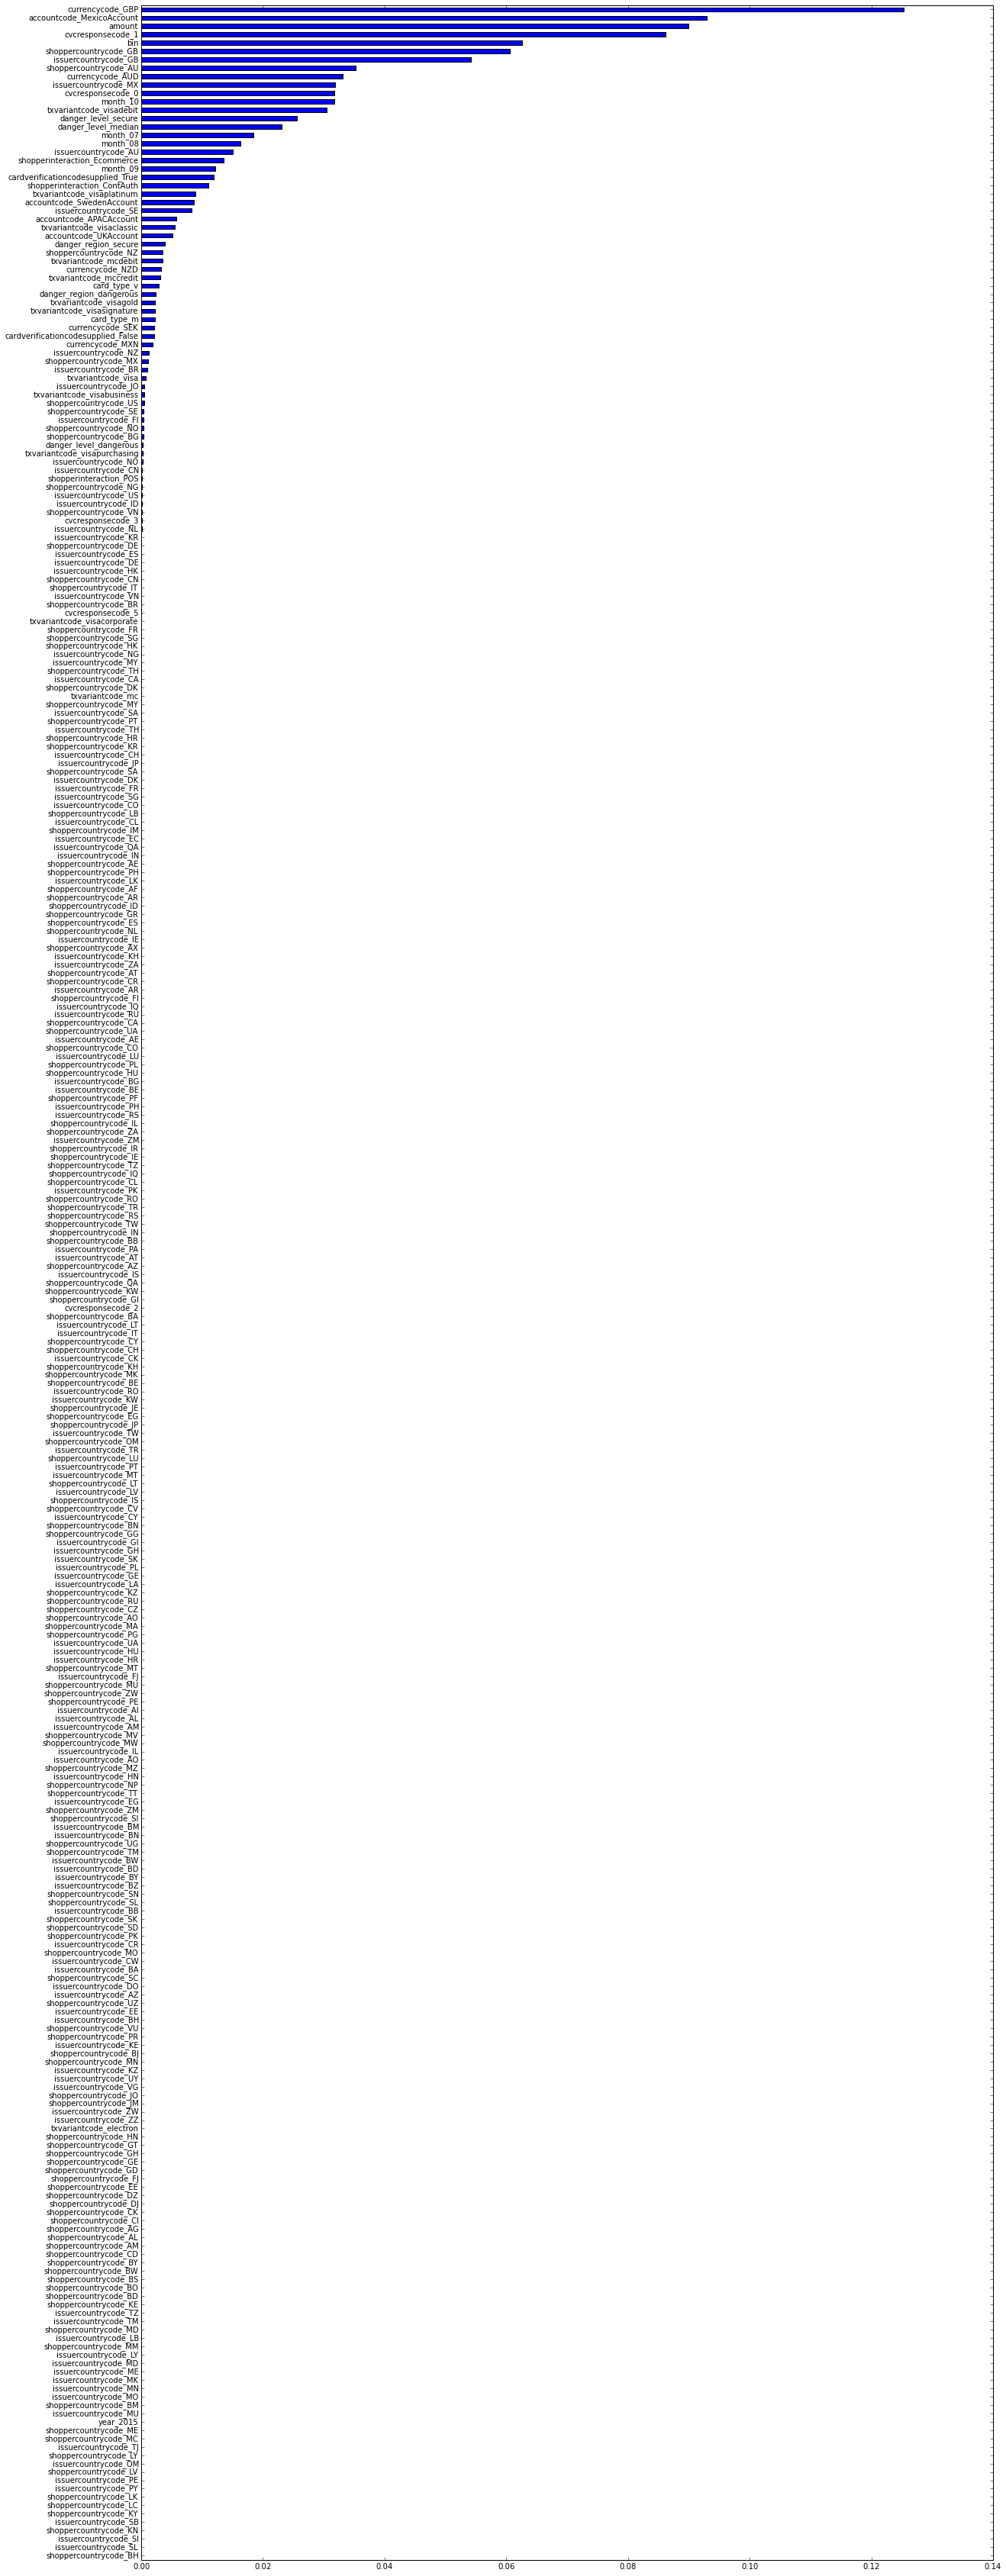

In [50]:
%matplotlib inline
feature_importance = pd.Series(forest.feature_importances_,index=X_compact.columns)#visualize feature importance
feature_importance.sort()
feature_importance.plot(kind="barh", figsize=(20,60))

In [51]:
#how many features is useful?
num_useful_features = len(feature_importance[feature_importance>0])
#select important features
important_features = feature_importance.argsort()[::-1][:num_useful_features+1]
#create data
X_matrix_fs = X_matrix[:,important_features]
X_matrix_fs

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_matrix_fs, y_matrix, random_state =0)#train test split

seen = SMOTEENN(ratio=800, verbose=verbose)
X_een, y_een = seen.fit_transform(X_train, y_train)
#train classifier
forest = ensemble.RandomForestClassifier()
#fit data
forest.fit(X_een, y_een)#fit rebalanced dataset
y_pred_forest = forest.predict(X_test)
print metrics.confusion_matrix(y_test, y_pred_forest)
print "RF Recall: " + str(metrics.recall_score(y_test,y_pred_forest))
print "RF Precision: " + str(metrics.precision_score(y_test, y_pred_forest))
print "RF F1: " + str(metrics.f1_score(y_test, y_pred_forest))

## 4. Classifier Comparison

### 4.1  Logistic, SVM(RBF)

In [44]:
#evaluate
#use a copy of data set
X_matrix = X_compact.as_matrix()
y_matrix = y_compact.as_matrix()
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_matrix, y_matrix, random_state =0)#train test split

seen = SMOTEENN(ratio=800, verbose=verbose)
X_een, y_een = seen.fit_transform(X_matrix, y_matrix)

In [45]:
evaluate_feature(X_een, X_test, y_een, y_test)

[[57431  1740]
 [   18    70]]
KNN Recall: 0.795454545455
KNN Precision: 0.0386740331492
KNN F1: 0.0737618545838
[[52289  6882]
 [   25    63]]
Logistic Recall: 0.715909090909
Logistic Precision: 0.00907127429806
Logistic F1: 0.0179155410209
[[59089    82]
 [   28    60]]
RF Recall: 0.681818181818
RF Precision: 0.422535211268
RF F1: 0.521739130435


In [57]:
seen = SMOTEENN(ratio=100, verbose=verbose)
X_een, y_een = seen.fit_transform(X_matrix, y_matrix)
for n_est in [200]:
    print("Current n_estimator is" + str(n_est) + ": ")
    adaboost_evaluate(X_een, X_test, y_een, y_test, n_est)
#    evaluate_feature(X_bsmote, X_test, y_bsmote, y_test)
print("Finished")

Current n_estimator is200: 
[[58808   363]
 [   63    25]]
ADA Recall: 0.284090909091
ADA Precision: 0.0644329896907
ADA F1: 0.105042016807
Finished


In [58]:
logistic = linear_model.LogisticRegression()
logistic.fit(X_een, y_een)
y_pred_log = logistic.predict(X_test)
print "Logistic Recall: " + str(metrics.recall_score(y_test,y_pred_log))
print "Logistic Precision: " + str(metrics.precision_score(y_test, y_pred_log))
print "Logistic F1: " + str(metrics.f1_score(y_test, y_pred_log))

Logistic Recall: 0.715909090909
Logistic Precision: 0.00907388736857
Logistic F1: 0.0179206371782


In [ ]:
svc = svm.SVC(kernel="rbf")
svc.fit(X_een, y_train)
y_pred_svm = svc.predict(X_test)
print "SVM Recall: " + str(metrics.recall_score(y_test,y_pred_svm))
print "SVM Precision: " + str(metrics.precision_score(y_test, y_pred_svm))
print "SVM F1: " + str(metrics.f1_score(y_test, y_pred_svm))

In [50]:
from sklearn.ensemble import AdaBoostClassifier
def adaboost_evaluate(X_train, X_test, y_train, y_test, n_est):
    """Use varies classifiers to evaluate based on confusion matrix, recall, precision, f1, using hold out crossvalidation
    Args:
        X_train(pandas.dataframe): training data
        X_test(pandas.dataframe): testing data
        y_train(pandas.series): training label
        y_test(pandas.series): testing label
    Returns:
        knn(KNearestneighboutClassifier): trained knn classifier
    """
    #train classifier
    ada = AdaBoostClassifier(n_estimators = n_est)
    #fit data
    ada.fit(X_train, y_train)
    #make prediction
    y_pred_ada = ada.predict(X_test)
    print(metrics.confusion_matrix(y_test,y_pred_ada))
    print("ADA Recall: " + str(metrics.recall_score(y_test,y_pred_ada)))
    print("ADA Precision: " + str(metrics.precision_score(y_test, y_pred_ada)))
    print("ADA F1: " + str(metrics.f1_score(y_test, y_pred_ada)))

### 4.2 Boosting - Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME", n_estimators=200)
ada.fit(X_een, y_een)
y_pred_ada = ada.predict(X_test)
print "Ada Recall: " + str(metrics.recall_score(y_test,y_pred_svm))
print "Ada Precision: " + str(metrics.precision_score(y_test, y_pred_svm))
print "Ada F1: " + str(metrics.f1_score(y_test, y_pred_svm))

### 4.3 Bagging - RandomForest

We've performed bagging in the beginning of this section, the result reveals that the un-tuned randomforest got 0.48 F1 Score, which is much better than linear models, and also better than boosting model.

## 5. Parameter Tuning

30 trees
0.533333333333

50 trees
0.545454545455

100 trees
0.543933054393

200 trees
0.546218487395

500 trees
0.541666666667

1000 trees
0.546218487395

2000 trees
0.546218487395



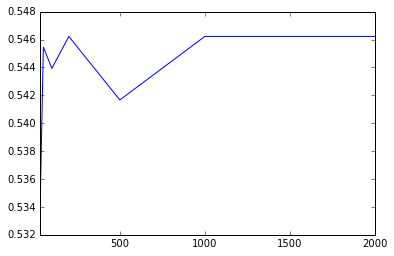

In [47]:
#tune number of trees
result = []
#grid search
n_estimator_options = [30,50,100,200,500,1000,2000]
for trees in n_estimator_options:
    model = ensemble.RandomForestClassifier(trees, oob_score=True, n_jobs=-1, random_state=0)
    model.fit(X_een,y_een)
    print(trees, "trees")
    y_pred_forest = model.predict(X_test)
    f1 = metrics.f1_score(y_test, y_pred_forest)
    print(f1)
    result.append(f1)
    print("")
pd.Series(result, n_estimator_options).plot()

1 min_samples
0.546218487395

2 min_samples
0.0670908039329

3 min_samples
0.0506441581519

4 min_samples
0.0344168260038

5 min_samples
0.0315865039483

6 min_samples
0.0300588107166

7 min_samples
0.0316957210777

8 min_samples
0.0299349240781

9 min_samples
0.0280314291782

10 min_samples
0.0284043441938



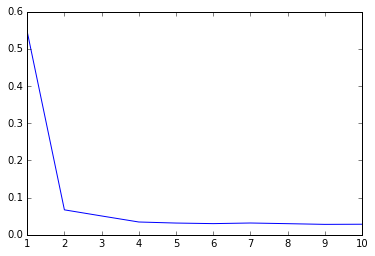

In [45]:
#tune leaf number
result = []
#grid search
min_samples_leaf_options = [1,2,3,4,5,6,7,8,9,10]
for min_samples in min_samples_leaf_options:
    model = ensemble.RandomForestClassifier(100, oob_score=True, n_jobs=-1, random_state=2, max_features="auto", min_samples_leaf=min_samples)
    model.fit(X_een,y_een)
    print(min_samples, "min_samples")
    y_pred_forest = model.predict(X_test)
    f1 = metrics.f1_score(y_test, y_pred_forest)
    print(f1)
    result.append(f1)
    print("")
pd.Series(result, min_samples_leaf_options).plot()

## 6. Unsupervised Learning